Calcule red_ratio pour chaque vidéo.



Affiche les performances de chaque modèle et leur seuil optimal (dans le cas 1D).

Trace les points en 2D pour voir la séparation Holo/No-Holo.

[!] Erreur ouverture : /content/drive/MyDrive/holo/passport_psp07_01_03_colored_mean_fixed.mp4
[!] Erreur ouverture : /content/drive/MyDrive/no-holo/passport_psp10_04_01_colored_mean_fixed.mp4

=== RÉSULTATS AVEC RÉGRESSION LOGISTIQUE ===
Nombre de vidéos Holo    : 9
Nombre de vidéos No-Holo : 11
Précision globale : 100.00%
Seuil red_ratio trouvé (p=0.5) : 0.6660


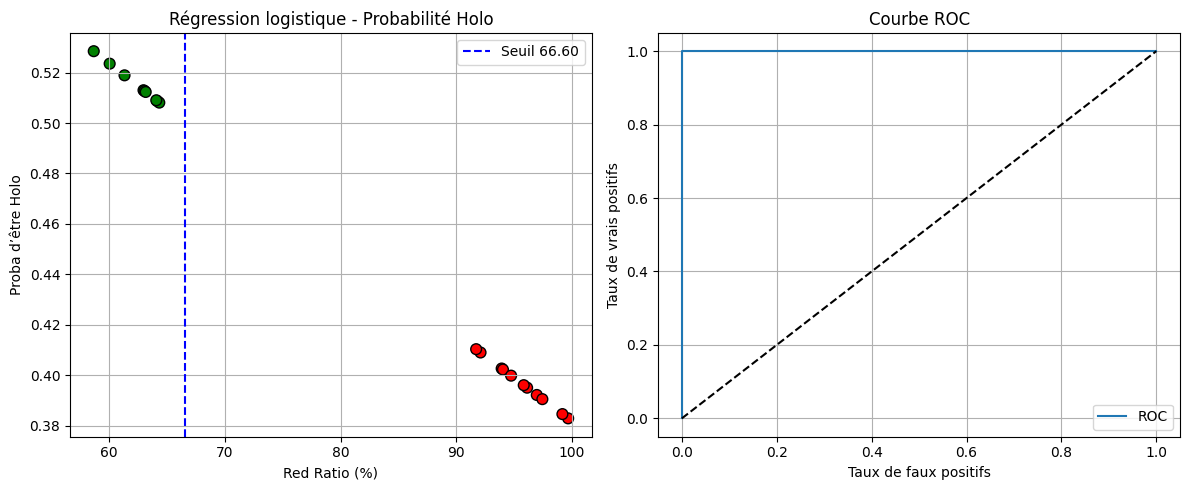

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve

# --- Paramètres ---
patch_height, patch_width = 28, 28
patch_size = (patch_height, patch_width)
min_saturation = 100
frame_interval = 10  # 1 frame sur 10

# --- Fonctions ---
def divide_image_into_patches(image, patch_size):
    height, width = image.shape[:2]
    patches = []
    for y in range(0, height, patch_size[0]):
        for x in range(0, width, patch_size[1]):
            patch = image[y:y + patch_size[0], x:x + patch_size[1]]
            if patch.shape[:2] != patch_size:
                patch = cv2.resize(patch, patch_size, interpolation=cv2.INTER_NEAREST)
            patches.append(patch)
    return patches

def get_patch_colors(patches, min_saturation=100):
    cpt_R, cpt_G = 0, 0
    for patch in patches:
        avg_b, avg_g, avg_r = patch.mean(axis=(0, 1))
        if avg_g > avg_r and avg_g > avg_b and avg_g > min_saturation:
            cpt_G += 1
        elif avg_r > avg_g and avg_r > avg_b and avg_r > min_saturation:
            cpt_R += 1
    return cpt_R, cpt_G

# --- Chemins ---
dossier_H = "/content/drive/MyDrive/holo"
dossier_NH = "/content/drive/MyDrive/no-holo"

red_ratios = []
labels = []
video_names = []

# --- Parcours des vidéos ---
for label_dir, label_value in [(dossier_H, 1), (dossier_NH, 0)]:
    for video_file in os.listdir(label_dir):
        if not video_file.lower().endswith(('.mp4', '.avi', '.mov')):
            continue

        video_path = os.path.join(label_dir, video_file)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"[!] Erreur ouverture : {video_path}")
            continue

        total_R, total_G, frame_idx = 0, 0, 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_idx % frame_interval == 0:
                patches = divide_image_into_patches(frame, patch_size)
                cpt_R, cpt_G = get_patch_colors(patches, min_saturation)
                total_R += cpt_R
                total_G += cpt_G

            frame_idx += 1

        cap.release()

        total_colored = total_R + total_G
        if total_colored == 0:
            print(f"[!] Aucun patch coloré : {video_file}")
            continue

        red_ratio = total_R / total_colored
        red_ratios.append(red_ratio)
        labels.append(label_value)
        video_names.append(video_file)

# --- Données en array ---
X = np.array(red_ratios).reshape(-1, 1)
y = np.array(labels)

# --- Entraînement régression logistique ---
clf = LogisticRegression()
clf.fit(X, y)

# --- Prédictions ---
probs = clf.predict_proba(X)[:, 1]
preds = (probs >= 0.5).astype(int)
accuracy = accuracy_score(y, preds)

# --- Seuil implicite et explicite ---
coef = clf.coef_[0][0]
intercept = clf.intercept_[0]
threshold = -intercept / coef

# --- Affichage résultats ---
print("\n=== RÉSULTATS AVEC RÉGRESSION LOGISTIQUE ===")
print(f"Nombre de vidéos Holo    : {sum(y==1)}")
print(f"Nombre de vidéos No-Holo : {sum(y==0)}")
print(f"Précision globale : {accuracy*100:.2f}%")
print(f"Seuil red_ratio trouvé (p=0.5) : {threshold:.4f}")

# --- ROC ---
fpr, tpr, _ = roc_curve(y, probs)

# --- Graphique décisionnel ---
colors = ['green' if label == 1 else 'red' for label in y]

plt.figure(figsize=(12, 5))

# 1. Scatter red_ratio
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0] * 100, probs, c=colors, edgecolor='k', s=60)
plt.axvline(threshold * 100, color='blue', linestyle='--', label=f'Seuil {threshold*100:.2f}')
plt.xlabel("Red Ratio (%)")
plt.ylabel("Proba d’être Holo")
plt.title("Régression logistique - Probabilité Holo")
plt.legend()
plt.grid(True)

# 2. ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label="ROC")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


[!] Erreur ouverture : /content/drive/MyDrive/holo/passport_psp07_01_03_colored_mean_fixed.mp4
[!] Erreur ouverture : /content/drive/MyDrive/no-holo/passport_psp10_04_01_colored_mean_fixed.mp4

=== RÉSULTATS AVEC RÉGRESSION LOGISTIQUE ===
Nombre de vidéos Holo (test)    : 3
Nombre de vidéos No-Holo (test) : 4
Précision test : 100.00%
Seuil red_ratio (p=0.5) : 0.6519


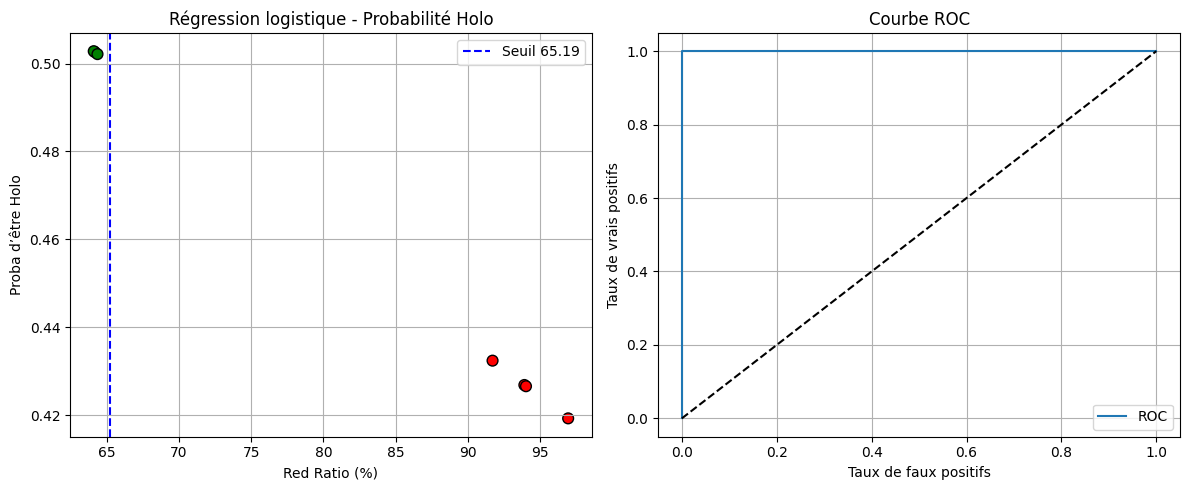

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Paramètres ---
patch_height, patch_width = 28, 28
patch_size = (patch_height, patch_width)
min_saturation = 100
frame_interval = 10  # 1 frame sur 10

# --- Fonctions ---
def divide_image_into_patches(image, patch_size):
    height, width = image.shape[:2]
    patches = []
    for y in range(0, height, patch_size[0]):
        for x in range(0, width, patch_size[1]):
            patch = image[y:y + patch_size[0], x:x + patch_size[1]]
            if patch.shape[:2] != patch_size:
                patch = cv2.resize(patch, patch_size, interpolation=cv2.INTER_NEAREST)
            patches.append(patch)
    return patches

def get_patch_colors(patches, min_saturation=100):
    cpt_R, cpt_G = 0, 0
    for patch in patches:
        avg_b, avg_g, avg_r = patch.mean(axis=(0, 1))
        if avg_g > avg_r and avg_g > avg_b and avg_g > min_saturation:
            cpt_G += 1
        elif avg_r > avg_g and avg_r > avg_b and avg_r > min_saturation:
            cpt_R += 1
    return cpt_R, cpt_G

# --- Chemins ---
dossier_H = "/content/drive/MyDrive/holo"
dossier_NH = "/content/drive/MyDrive/no-holo"

red_ratios = []
labels = []
video_names = []

# --- Lecture vidéos ---
for label_dir, label_value in [(dossier_H, 1), (dossier_NH, 0)]:
    for video_file in os.listdir(label_dir):
        if not video_file.lower().endswith(('.mp4', '.avi', '.mov')):
            continue

        video_path = os.path.join(label_dir, video_file)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"[!] Erreur ouverture : {video_path}")
            continue

        total_R, total_G, frame_idx = 0, 0, 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_idx % frame_interval == 0:
                patches = divide_image_into_patches(frame, patch_size)

                # --- Data augmentation (flip horizontal)
                flipped = [cv2.flip(patch, 1) for patch in patches]
                patches += flipped

                cpt_R, cpt_G = get_patch_colors(patches, min_saturation)
                total_R += cpt_R
                total_G += cpt_G

            frame_idx += 1

        cap.release()

        total_colored = total_R + total_G
        if total_colored == 0:
            print(f"[!] Aucun patch coloré : {video_file}")
            continue

        red_ratio = total_R / total_colored
        red_ratios.append(red_ratio)
        labels.append(label_value)
        video_names.append(video_file)

# --- Données en array ---
X = np.array(red_ratios).reshape(-1, 1)
y = np.array(labels)

# --- Split et entraînement ---
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

# --- Prédictions ---
probs = clf.predict_proba(X_test)[:, 1]
preds = (probs >= 0.5).astype(int)
accuracy = accuracy_score(y_test, preds)

# --- Calcul du seuil red_ratio (p=0.5) ---
coef = clf.coef_[0][0]
intercept = clf.intercept_[0]
threshold = -intercept / coef

# --- Affichage résultats ---
print("\n=== RÉSULTATS AVEC RÉGRESSION LOGISTIQUE ===")
print(f"Nombre de vidéos Holo (test)    : {sum(y_test==1)}")
print(f"Nombre de vidéos No-Holo (test) : {sum(y_test==0)}")
print(f"Précision test : {accuracy*100:.2f}%")
print(f"Seuil red_ratio (p=0.5) : {threshold:.4f}")

# --- Courbes ROC + visualisation ---
fpr, tpr, _ = roc_curve(y_test, probs)
colors = ['green' if label == 1 else 'red' for label in y_test]

plt.figure(figsize=(12, 5))

# 1. Scatter red_ratio
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0] * 100, probs, c=colors, edgecolor='k', s=60)
plt.axvline(threshold * 100, color='blue', linestyle='--', label=f'Seuil {threshold*100:.2f}')
plt.xlabel("Red Ratio (%)")
plt.ylabel("Proba d’être Holo")
plt.title("Régression logistique - Probabilité Holo")
plt.legend()
plt.grid(True)

# 2. ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label="ROC")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Chaque vidéo est représentée par un ratio green_ratio (patchs verts / total).

Une régression logistique est entraînée à classifier les vidéos selon ce ratio.

Un seuil optimal est calculé automatiquement.
un résumé du nombre de vidéos Holo et No-Holo, et un graphe clair des classifications.

AVEC SEUIL MIN/MAX

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# --- Paramètres ---
patch_height, patch_width = 28, 28
patch_size = (patch_height, patch_width)
min_saturation = 100

# --- Fonctions ---
def divide_image_into_patches(image, patch_size):
    height, width = image.shape[:2]
    patches = []
    for y in range(0, height, patch_size[0]):
        for x in range(0, width, patch_size[1]):
            patch = image[y:y + patch_size[0], x:x + patch_size[1]]
            if patch.shape[:2] != patch_size:
                patch = cv2.resize(patch, patch_size, interpolation=cv2.INTER_NEAREST)
            patches.append(patch)
    return patches

def get_patch_colors(patches, min_saturation=100):
    cpt_R, cpt_G = 0, 0
    for patch in patches:
        avg_b, avg_g, avg_r = patch.mean(axis=(0, 1))
        if avg_g > avg_r and avg_g > avg_b and avg_g > min_saturation:
            cpt_G += 1
        elif avg_r > avg_g and avg_r > avg_b and avg_r > min_saturation:
            cpt_R += 1
    return cpt_R, cpt_G

# --- Chemins ---
dossier_H = "/content/drive/MyDrive/holo"
dossier_NH = "/content/drive/MyDrive/no-holo"

green_ratios = []
labels = []
video_names = []

# --- Analyse des vidéos ---
for label_dir, label_value in [(dossier_H, 1), (dossier_NH, 0)]:
    print(f"\nExploration de {label_dir}")
    for video_folder in os.listdir(label_dir):
        folder_path = os.path.join(label_dir, video_folder)
        if not os.path.isdir(folder_path):
            continue
        print(f"  → Traitement de : {folder_path}")

        total_R, total_G = 0, 0

        for img_name in os.listdir(folder_path):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"[!] Image non lue : {img_path}")
                continue
            patches = divide_image_into_patches(img, patch_size)
            cpt_R, cpt_G = get_patch_colors(patches, min_saturation)
            total_R += cpt_R
            total_G += cpt_G

        total_colored = total_R + total_G
        if total_colored == 0:
            print(f"[!] Aucun patch coloré dans {folder_path}")
            continue

        green_ratio = total_G / total_colored
        green_ratios.append(green_ratio)
        labels.append(label_value)
        video_names.append(video_folder)

# --- Analyse des ratios ---
green_ratios = np.array(green_ratios)
labels = np.array(labels)

ratios_holo = green_ratios[labels == 1]
ratios_noholo = green_ratios[labels == 0]

min_holo = ratios_holo.min()
max_noholo = ratios_noholo.max()

# --- Calcul du seuil optimal entre les deux classes ---
threshold = (min_holo + max_noholo) / 2
predicted = (green_ratios >= threshold).astype(int)

# --- Résumé ---
accuracy = accuracy_score(labels, predicted)
n_total = len(labels)
n_holo = sum(labels)
n_noholo = n_total - n_holo

print(f"\nTotal vidéos analysées : {n_total}")
print(f"Holo     : {n_holo} ({100 * n_holo / n_total:.1f}%)")
print(f"No-Holo  : {n_noholo} ({100 * n_noholo / n_total:.1f}%)")
print(f"Green ratio (No-Holo) : min={ratios_noholo.min()*100:.2f}, max={ratios_noholo.max()*100:.2f}")
print(f"Green ratio (Holo)    : min={ratios_holo.min()*100:.2f}, max={ratios_holo.max()*100:.2f}")
print(f"Seuil optimal entre les deux classes : {threshold*100:.2f}")
print(f"Précision globale : {accuracy * 100:.2f}%")

# --- Visualisation ---
colors = ['green' if l == 0 else 'red' for l in labels]

plt.figure(figsize=(10, 5))
plt.scatter(green_ratios * 100, np.zeros_like(green_ratios), c=colors, s=60, edgecolors='k')
plt.axvline(x=threshold * 100, color='blue', linestyle='--', label=f'Seuil = {threshold*100:.2f}')
plt.xlabel("Green Ratio (×100)")
plt.title("Classification Holo / No-Holo par seuil min/max")
plt.legend()
plt.yticks([])
plt.grid(True)
plt.show()



Exploration de /content/drive/MyDrive/holo
  → Traitement de : /content/drive/MyDrive/holo/.ipynb_checkpoints
[!] Aucun patch coloré dans /content/drive/MyDrive/holo/.ipynb_checkpoints

Exploration de /content/drive/MyDrive/no-holo
  → Traitement de : /content/drive/MyDrive/no-holo/.ipynb_checkpoints
[!] Aucun patch coloré dans /content/drive/MyDrive/no-holo/.ipynb_checkpoints


ValueError: zero-size array to reduction operation minimum which has no identity

 seuil par régression logistique

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# --- Paramètres ---
patch_height, patch_width = 28, 28
patch_size = (patch_height, patch_width)
min_saturation = 100

# --- Fonctions ---
def divide_image_into_patches(image, patch_size):
    height, width = image.shape[:2]
    patches = []
    for y in range(0, height, patch_size[0]):
        for x in range(0, width, patch_size[1]):
            patch = image[y:y + patch_size[0], x:x + patch_size[1]]
            if patch.shape[:2] != patch_size:
                patch = cv2.resize(patch, patch_size, interpolation=cv2.INTER_NEAREST)
            patches.append(patch)
    return patches

def get_patch_colors(patches, min_saturation=100):
    cpt_R, cpt_G = 0, 0
    for patch in patches:
        avg_b, avg_g, avg_r = patch.mean(axis=(0, 1))
        if avg_g > avg_r and avg_g > avg_b and avg_g > min_saturation:
            cpt_G += 1
        elif avg_r > avg_g and avg_r > avg_b and avg_r > min_saturation:
            cpt_R += 1
    return cpt_R, cpt_G

# --- Chemins ---
dossier_H = "/content/drive/MyDrive/holo"
dossier_NH = "/content/drive/MyDrive/no-holo"

green_ratios = []
labels = []
video_names = []

# --- Analyse des vidéos ---
for label_dir, label_value in [(dossier_H, 1), (dossier_NH, 0)]:
    print(f"\nExploration de {label_dir}")
    for video_folder in os.listdir(label_dir):
        folder_path = os.path.join(label_dir, video_folder)
        if not os.path.isdir(folder_path):
            continue
        print(f"  → Traitement de : {folder_path}")

        total_R, total_G = 0, 0

        for img_name in os.listdir(folder_path):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"[!] Image non lue : {img_path}")
                continue
            patches = divide_image_into_patches(img, patch_size)
            cpt_R, cpt_G = get_patch_colors(patches, min_saturation)
            total_R += cpt_R
            total_G += cpt_G

        total_colored = total_R + total_G
        if total_colored == 0:
            print(f"[!] Aucun patch coloré dans {folder_path}")
            continue

        green_ratio = total_G / total_colored
        green_ratios.append(green_ratio)
        labels.append(label_value)
        video_names.append(video_folder)

# --- Analyse des ratios ---
green_ratios = np.array(green_ratios).reshape(-1, 1)
labels = np.array(labels)

ratios_holo = green_ratios[labels == 1]
ratios_noholo = green_ratios[labels == 0]

min_holo = ratios_holo.min()
max_noholo = ratios_noholo.max()

# --- Apprentissage par régression logistique ---
clf = LogisticRegression()
clf.fit(green_ratios, labels)

# Seuil calculé automatiquement
threshold_lr = -clf.intercept_[0] / clf.coef_[0][0]

# --- Correction du seuil pour forcer séparation logique ---
# Si le seuil est hors de la plage logique, on le force
threshold = np.clip(threshold_lr, max_noholo, min_holo)

# --- Prédiction & évaluation ---
predicted = (green_ratios >= threshold).astype(int)
accuracy = accuracy_score(labels, predicted)

# --- Résumé ---
n_total = len(labels)
n_holo = sum(labels)
n_noholo = n_total - n_holo

print(f"\nTotal vidéos analysées : {n_total}")
print(f"Holo     : {n_holo} ({100 * n_holo / n_total:.1f}%)")
print(f"No-Holo  : {n_noholo} ({100 * n_noholo / n_total:.1f}%)")
print(f"Green ratio (No-Holo) : min={ratios_noholo.min()*100:.2f}, max={ratios_noholo.max()*100:.2f}")
print(f"Green ratio (Holo)    : min={ratios_holo.min()*100:.2f}, max={ratios_holo.max()*100:.2f}")
print(f"Seuil appris = {threshold_lr*100:.2f} → ajusté = {threshold*100:.2f}")
print(f"Précision globale : {accuracy * 100:.2f}%")

# --- Visualisation ---
colors = ['green' if l == 0 else 'red' for l in labels]

plt.figure(figsize=(10, 5))
plt.scatter(green_ratios * 100, np.zeros_like(green_ratios), c=colors, s=60, edgecolors='k')
plt.axvline(x=threshold * 100, color='blue', linestyle='--', label=f'Seuil = {threshold*100:.2f}')
plt.xlabel("Green Ratio (×100)")
plt.title("Classification Holo / No-Holo par régression logistique")
plt.legend()
plt.yticks([])
plt.grid(True)
plt.show()


calculer le red ratio aulieu de green ratio entre copy without  holo et holo !

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
